# Networks and NetworkX II

This notebook continues in demonstrating more advanced concepts in
network analysis pertaining to archeology and provides a hands-on
tutorial to using the NetworkX Python library for these applications.

### 0. Prerequisites

-   Read through and follow the instructions in the pre-reading
-   Have read through the first Networks and NetworkX module
-   If neither of those have been completed go back to those modules
    first

We will continue where we left off in Networks and NetworkX and
continute looking at applications of Network analysis for
anthropological purposes.

### 1 Libraries

Here we are importing libraries necessary to run our upcoming code. Our
code will be built using commands from them.

In [1]:
#import libraries needed for the notebook 
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches 
import networkx as nx 
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import community as community_louvain
import random
import matplotlib.animation as animation
from ipywidgets import interact, FloatRangeSlider, Layout
from shapely.geometry import box
import plotly.graph_objects as go

In [2]:
#Let's us open the datasets in Google Collab easily
import os
os.system("wget https://github.com/ubcecon/ai-workshop/blob/ccss-networks.zip")
os.system("ccss-networks")

csv_path = ("https://github.com/ubcecon/ai-workshop/blob/ccss-networks/data")

### 2. Importing our Dataset

We are using the same dataset from the first notebook, just with
different applications. Importantly the process of uploading and
manipulating the dataset is identical to the first notebook. Below is a
large codeblock which will output our more zoomed in map of the Aegean
sea from the first notebook as a test to see if the data is properly
imported and working.

In [3]:
# Load data and create our graph
df_edges = pd.read_excel("vistorian_network.xls")
G = nx.from_pandas_edgelist(df_edges, source="SOURCE_LOCATION", target="TARGET_LOCATION")

# Load and process location data
df_pos = pd.read_excel("vistorian_locations.xls", index_col=0)
gdf_pos = gpd.GeoDataFrame(df_pos, geometry=gpd.points_from_xy(df_pos['LONGITUDE'], df_pos['LATITUDE']), crs='EPSG:4326')
gdf_pos = gdf_pos.to_crs('EPSG:3857')

# Create boundaries
min_x, min_y = 1858948, 4055442
max_x, max_y = 3336323, 5175704

# Filter GeoDataFrame and make a subgraph
gdf_pos_filtered = gdf_pos.cx[min_x:max_x, min_y:max_y]
filtered_nodes = gdf_pos_filtered.index.tolist()
G_sub = G.subgraph(filtered_nodes)

# Prepare positions for the subgraph
positions_filtered = {loc: (gdf_pos_filtered.loc[loc].geometry.x, gdf_pos_filtered.loc[loc].geometry.y) for loc in gdf_pos_filtered.index}

# Plot the filtered subgraph
fig, ax = plt.subplots(figsize=(9, 9))
gdf_pos_filtered.plot(ax=ax, alpha=0)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

#Draw our network
nx.draw_networkx_edges(G_sub, pos=positions_filtered, ax=ax, alpha=0.1)
nx.draw_networkx_nodes(G_sub, pos=positions_filtered, ax=ax, node_size=60, node_color="red", edgecolors="black", alpha=0.8)

#Show the plot
plt.show()

### 3 What is the number of edges?

A question which is not immediatly apparent looking at the graph above
is how many edges each node has? This can be computed and can be helpful
for analysis as by just looking at the graph it is impossible to count
the lines. To use this we use a command in NetworkX `nx.core_number`
which find the core number of each node.

The core number of a node is the largest value k for which the node
belongs to a k-core. A k-core is a maximal subgraph in which all
vertices have degree at least k. Computing this will give us the amount
of edges for each node.

In [4]:
# Define a function to count edges for each node, two parameters: G (Graphical object) and K(edges)
def count_nodes_with_k_edges(G, k):
    G = G.copy()
    G.remove_edges_from(nx.selfloop_edges(G))
    core_numbers = nx.core_number(G)
    count = sum(1 for cn in core_numbers.values() if cn >= k)
    
    return count

# Using df_pos to set a range for the process
gdf_pos = gpd.GeoDataFrame(df_pos, geometry=gpd.points_from_xy(df_pos['LONGITUDE'], df_pos['LATITUDE']), crs='EPSG:4326')
gdf_pos = gdf_pos.to_crs('EPSG:3857')

# This is the range (Bounding Box)
min_x, min_y = 1858948, 4055442
max_x, max_y = 3336323, 5175704

#Filter the graph using the bounds above
gdf_pos_filtered = gdf_pos.cx[min_x:max_x, min_y:max_y] 
filtered_nodes = gdf_pos_filtered.index.tolist()

# Create a subgraph of our filtered nodes
G_sub = G.subgraph(filtered_nodes) 

# Print degree of each node
print("\nDegree of each node in the filtered subgraph:")
for node in G_sub.nodes():
    print(f"Node {node}: {G_sub.degree(node)} edges")

This output is also helpful because for the coming sections we will need
the individual node names.

## 4 Path Analysis

What is path analysis? In this context it is finding the shortest,
average or longest path between two or more nodes. Often in the real
world you need to find the shortest path between two points (this could
be for transportation, information transmission etc). It is one of the
most common applications of network analysis.

### 4.1 Path Analysis on a small graph

We can use path analysis to find shortest path from a point or average
path lenght. We are using new notation in our `nx.Graph` function we are
adding a lenght between points which is shown as `('B', 'D', LENGHT)`
this lenght will be shown in the graph and has to be taken into account
for finding the shortest path.

The other new important command fron NetworkX we are using is
`nx.shortest_path` which takes a start and end point then finds the
lenght and shortest path between them. We will look for the shortest
path from node 9 to node 5. Then using the command
`nx.draw_networkx_edges` we will highlight the shortest path in blue.

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import random

# Set a random seed for reproducibility
random.seed(3)

# Create a random regular graph
n = 12  # number of nodes
d = 3   # degree of each node
G = nx.random_regular_graph(d, n)

# Assign random weights to edges
for (u, v) in G.edges():
    G[u][v]['weight'] = random.randint(1, 10)

#Define a function which finds the shortest path
def find_shortest_path(G, start, end):
    try:
        path = nx.shortest_path(G, start, end, weight='weight')
        length = nx.shortest_path_length(G, start, end, weight='weight')
        return path, length
    except nx.NetworkXNoPath:
        return None, None

def main():
    # Create a random regular graph
    n = 10  # number of nodes (increased to at least 10)
    d = 3   # degree of each node
    G = nx.random_regular_graph(d, n)

    # Assign random weights to edges
    for (u, v) in G.edges():
        G[u][v]['weight'] = random.randint(1, 10)

    # Find shortest path from node 4 to node 9
    start, end = 9, 5
    path, length = find_shortest_path(G, start, end)
    if path:
        print(f"Shortest path from {start} to {end}: {' -> '.join(map(str, path))}")
        print(f"Path length: {length}")
  
    # Visualize the graph
    pos = nx.spring_layout(G, seed=42)
    
    # Draw the graph
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=16, font_weight='bold')
    
    # Draw edge labels
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    
    # Highlight the shortest path in blue
    if path:
        path_edges = list(zip(path, path[1:]))
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='b', width=2)
    
    plt.title("Random Regular Graph with Shortest Path")
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    main()

### 4.2 Path Analysis on our data

Let’s say we are intested in finding the shortest path from Veloukovo in
mainland Greece to Delos (an island in the Aegean). If we were to just
look at the graph it would be difficult to find. The code below will
find the shortest path.

Once again we will use `nx.shortest_path` this can also be easily edited
to find the shortest path from any node name. It can be done by editing
the variables `start` and `end`.

In [6]:
# Find shortest path from Veloukovo to Delos
Start = "Veloukovo"
End = "Delos"

# use a full path
G_full = nx.from_pandas_edgelist(df_edges, source="SOURCE_LOCATION", target="TARGET_LOCATION")

G_sub = G_full.subgraph(filtered_nodes)

shortest_path = nx.shortest_path(G_full, source=Start, target=End)

# Calculate the path length
path_length = nx.shortest_path_length(G_full, source=Start, target=End)

# Print the shortest path and length
print(f"Shortest path from {Start} to {End}:")
print(" -> ".join(shortest_path))
print(f"Path length: {path_length}")

If we want to visualy demonstate this distance we can plot it on the map
with a blue line. The code below will do this and using the command
`nx.draw_networkx_edges` we can draw a blue line to demonstate the
optimal path.

In [7]:
#Create a full map
G_full = nx.from_pandas_edgelist(df_edges, source="SOURCE_LOCATION", target="TARGET_LOCATION")

G_sub = G_full.subgraph(filtered_nodes)

#Find the positions of Nodes
positions = {loc: (gdf_pos_filtered.loc[loc].geometry.x, gdf_pos_filtered.loc[loc].geometry.y) for loc in gdf_pos_filtered.index}

# Plot the graph
fig, ax = plt.subplots(figsize=(8, 8))

# Plot filtered nodes and edges
nx.draw_networkx_edges(G_sub, pos=positions, ax=ax, alpha=0.1)
nx.draw_networkx_nodes(G_sub, pos=positions, ax=ax, node_size=20, node_color="red", alpha=0.6)

# Highlight the shortest path (only the part within the filtered area)
path_edges = list(zip(shortest_path, shortest_path[1:]))
path_edges_filtered = [edge for edge in path_edges if edge[0] in filtered_nodes and edge[1] in filtered_nodes]
nx.draw_networkx_edges(G_sub, pos=positions, ax=ax, edgelist=path_edges_filtered, edge_color='blue', width=2)

# Highlight Veloukovo and Delos 
highlight_nodes = [node for node in ["Veloukovo", "Delos"] if node in filtered_nodes]
nx.draw_networkx_nodes(G_sub, pos=positions, ax=ax, nodelist=highlight_nodes, 
                       node_color="yellow", node_size=100, edgecolors="black")

# Add labels for Veloukovo and Delos
labels = {node: node for node in highlight_nodes}
nx.draw_networkx_labels(G_sub, pos=positions, ax=ax, labels=labels, 
                        font_size=10, font_weight="bold")
ax.axis('off')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)

#Show our graph
plt.tight_layout()
plt.show()

Our dataset is very interconnected with most nodes having over 20 edges,
but for a less interconnected network this analysis could prove very
useful to find the shortest path.

### 5 Diffusion

Another application of network analysis is to do with the diffusion of
innovation, ideas or a disease through a network. We will demonstrate it
below with a gif. The code is complicated, but the goal for it is to act
as an interesting demonstarting of what is possible with Network
Analysis.

In [8]:
#Import specific libraries to create a gif
import matplotlib.animation as animation
from IPython.display import HTML, display
import base64

# Add a random seed for reproducability everytime our code runs
random.seed(3)

# Create a function to simulate the diffusion
def simulate_diffusion(G, initial_infected, steps, infection_probability):
    infected = set(initial_infected)
    infection_times = {node: 0 for node in initial_infected}
    
    for step in range(1, steps + 1):
        new_infected = set()
        for node in infected:
            for neighbor in G.neighbors(node):
                if neighbor not in infected and neighbor not in new_infected:
                    if random.random() < infection_probability:
                        new_infected.add(neighbor)
                        infection_times[neighbor] = step
        infected.update(new_infected)
        yield infected, infection_times

def update(frame):
    infected, infection_times = frame
    colors = ['red' if node in infected else 'blue' for node in G.nodes()]
    ax.clear()
    nx.draw(G, pos, node_color=colors, with_labels=True, ax=ax)
    ax.set_title(f"Time step: {max(infection_times.values())}")
    return ax

# Create a graph
G = nx.karate_club_graph()
pos = nx.spring_layout(G)

# Set up the initial infected nodes and parameters
initial_infected = [0]
infection_probability = 0.15
steps = 18

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Create the animation
ani = animation.FuncAnimation(
    fig, 
    update, 
    frames=simulate_diffusion(G, initial_infected, steps, infection_probability),
    interval=750, 
    repeat=False,
    save_count=steps
)

# Save the animation as GIF
ani.save('diffusion_process.gif', writer='pillow')
print("Animation saved as 'diffusion_process.gif'")

# Display the saved GIF in the notebook
with open("diffusion_process.gif", "rb") as file:
    gif_data = file.read()
    encoded_gif = base64.b64encode(gif_data).decode('utf-8')
    display(HTML(f'<img src="data:image/gif;base64,{encoded_gif}" width="600">'))

plt.close(fig)

Above is a demonstration of diffusion across a graph, you can customize
the infection rate, which nodes start infected and the shape of the
graph itself.

## 6. Interactive Network Exploration

Using Python and Network Analysis you can construct interesting and
interactive graphical displays. These range from hoverable node names,
panning and zooming, filtering of networks and other cool
visualziations. The code is complicated and should more serve to give
ideas on what can be done for anthropolgical applications using Python
and network analysis.

### 6.1 A pannable and zoomable map

We can use python to create a pannable and zoomable map of a random
graph.

In [9]:
import plotly.graph_objects as go
import networkx as nx

G = nx.random_geometric_graph(200, 0.125)
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

edge_trace = go.Scatter(x=edge_x, y=edge_y, line=dict(width=0.5, color='#888'), hoverinfo='none', mode='lines')

node_x = [x for x, y in nx.get_node_attributes(G, 'pos').values()]
node_y = [y for x, y in nx.get_node_attributes(G, 'pos').values()]
node_trace = go.Scatter(x=node_x, y=node_y, mode='markers', hoverinfo='text', marker=dict(showscale=True, colorscale='YlGnBu', size=10))

fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(showlegend=False, hovermode='closest',
                                 margin=dict(b=20,l=5,r=5,t=40)))
fig.show()

At the top right of the map you have options on what you can do, you can
filter using a box or lasso, download it, or just pan/zoom looking at
the network. Using the Box select tool you can easily view smaller
portions of the graph.

### 6.2 An interactive display of our data

Here we can look at an interactive map on our dataset of the Aegean Sea.
Because of the way the plugin to make these notebook works the edges are
missing and you can’t scroll to zoom in and out. If you run this code
locally with Python installed on your system the visualization is
different. This is still worth showing to demonstrate how visualization
can look.

In [10]:
from shapely.geometry import box
import geopandas as gpd
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

# Create a box geometry
bbox_geometry = box(min_x, min_y, max_x, max_y)

# Create a GeoDataFrame with the box geometry
bbox = gpd.GeoDataFrame(geometry=[bbox_geometry], crs=gdf_pos.crs)

# Filter GeoDataFrame and create subgraph
gdf_pos_filtered = gdf_pos.cx[min_x:max_x, min_y:max_y]
filtered_nodes = gdf_pos_filtered.index.tolist()
G_sub = G.subgraph(filtered_nodes)

# Now convert to EPSG:4326 for plotting
gdf_pos_filtered = gdf_pos_filtered.to_crs('EPSG:4326')

# Create edge traces
edge_traces = []
for edge in G_sub.edges():
    x0, y0 = gdf_pos_filtered.loc[edge[0], 'geometry'].x, gdf_pos_filtered.loc[edge[0], 'geometry'].y
    x1, y1 = gdf_pos_filtered.loc[edge[1], 'geometry'].x, gdf_pos_filtered.loc[edge[1], 'geometry'].y
    edge_trace = go.Scattermapbox(
        lon=[x0, x1],
        lat=[y0, y1],
        mode='lines',
        line=dict(width=1, color='rgba(136, 136, 136, 0.5)'),
        hoverinfo='none'
    )
    edge_traces.append(edge_trace)

# Create node trace
node_trace = go.Scattermapbox(
    lon=gdf_pos_filtered.geometry.x,
    lat=gdf_pos_filtered.geometry.y,
    mode='markers',
    marker=dict(
        size=10,
        color='red',
        opacity=0.8
    ),
    text=[f"Node: {node}" for node in G_sub.nodes()],
    hoverinfo='text'
)

# Create the figure
fig = go.Figure(data=edge_traces + [node_trace])

# Update layout to use mapbox
fig.update_layout(
    mapbox=dict(
        style="open-street-map",
        center=dict(lon=gdf_pos_filtered.geometry.x.mean(), lat=gdf_pos_filtered.geometry.y.mean()),
        zoom=7
    ),
    showlegend=False,
    margin={"l":0,"r":0,"t":0,"b":0}
)

fig.show()

# Print some information for verification
print(f"Number of filtered nodes: {len(gdf_pos_filtered)}")
print(f"Number of edges in subgraph: {len(G_sub.edges())}")

On this map you can pan and zoom, the edges don’t render, but for that
exercise that is ok. You can also use the box or lasso select tools to
look at smaller portions of our network.

The code block below here is a second example, the edges still don’t
render, but this time you can hover over the nodes to see the name and
the latitude and longitude.

In [11]:
from shapely.geometry import box
import geopandas as gpd
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

# Set the default renderer
pio.renderers.default = "notebook"

# Create a box geometry
bbox_geometry = box(min_x, min_y, max_x, max_y)

# Create a GeoDataFrame with the box geometry
bbox = gpd.GeoDataFrame(geometry=[bbox_geometry], crs=gdf_pos.crs)

# Filter GeoDataFrame and create subgraph
gdf_pos_filtered = gdf_pos.cx[min_x:max_x, min_y:max_y]
filtered_nodes = gdf_pos_filtered.index.tolist()
G_sub = G.subgraph(filtered_nodes)

# Now convert to EPSG:4326 for plotting
gdf_pos_filtered = gdf_pos_filtered.to_crs('EPSG:4326')

# Extract coordinates
gdf_pos_filtered['lon'] = gdf_pos_filtered.geometry.x
gdf_pos_filtered['lat'] = gdf_pos_filtered.geometry.y

# Create edge traces
edge_traces = []
for edge in G_sub.edges():
    x0, y0 = gdf_pos_filtered.loc[edge[0], ['lon', 'lat']]
    x1, y1 = gdf_pos_filtered.loc[edge[1], ['lon', 'lat']]
    edge_trace = go.Scattermapbox(
        lon=[x0, x1],
        lat=[y0, y1],
        mode='lines',
        line=dict(width=1, color='rgba(136, 136, 136, 0.5)'),
        hoverinfo='none'
    )
    edge_traces.append(edge_trace)

# Create the figure using Plotly Express
fig = px.scatter_mapbox(gdf_pos_filtered, 
                        lat="lat", 
                        lon="lon", 
                        hover_name=gdf_pos_filtered.index,
                        zoom=7,
                        height=600)

# Add edge traces
fig.add_traces(edge_traces)

# Update layout
fig.update_layout(
    mapbox_style="open-street-map",
    showlegend=False,
    margin={"l":0,"r":0,"t":0,"b":0}
)

# Show the figure
fig.show()

# Print some information for verification
print(f"Number of filtered nodes: {len(gdf_pos_filtered)}")
print(f"Number of edges in subgraph: {len(G_sub.edges())}")

This demonstration is not perfect, when the code is ran locally it works
much better with the edges rendering. Below is a screenshot from my own
machine showing how it would would look locally.

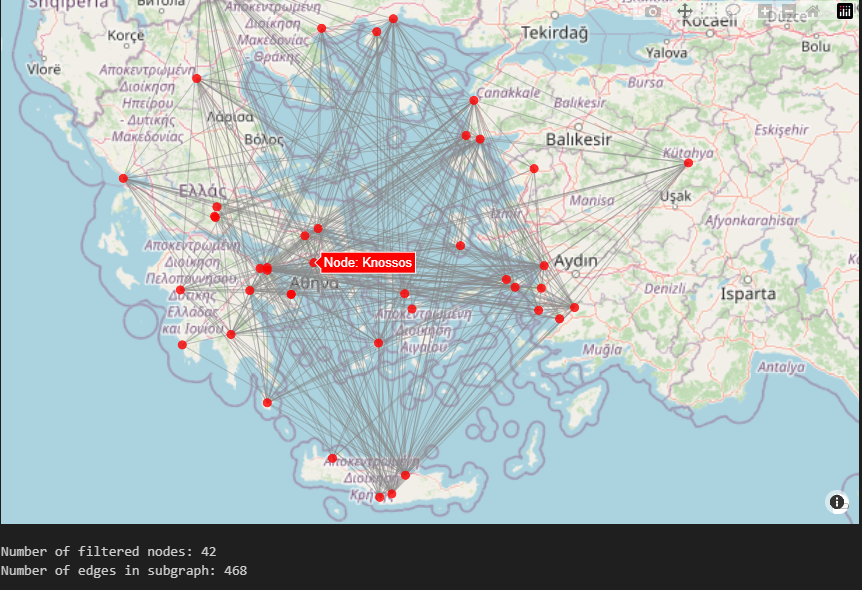

On this map you can pan, zoom, hover over nodes, and use the box and
lasso select tools.

## 7. Citations

Al-Taie, Mohammed Zuhair, and Seifedine Kadry. *Python for Graph and
Network Analysis*. Springer, 2017, doi:10.1007/978-3-319-53004-8.

Ashkan, Amir. “Animate Graph Diffusion with NetworkX.” *Stack Overflow*,
27 May 2015, https://stackoverflow.com/q/31815454.

Brughmans, Tom, and Benjamin Bach. “The Vistorian: Exploring
Archaeological Networks.” *Archaeological Networks*, 2018,
https://archaeologicalnetworks.wordpress.com/resources/.

Georgiev, Petko. “NetworkX: Network Analysis with Python.” *University
of Cambridge*, Feb. 2015,
www.cl.cam.ac.uk/teaching/1415/L109/l109-tutorial_2015.pdf.

McKinney, Trenton. “Introduction to Network Analysis in Python.” *GitHub
Pages*, 22 May 2020,
trenton3983.github.io/posts/intro-network-analysis/.

NetworkX Developers. *NetworkX/NetworkX: Network Analysis in Python*.
GitHub, 2005-2024, github.com/networkx/networkx. Accessed 26 Sept. 2023.